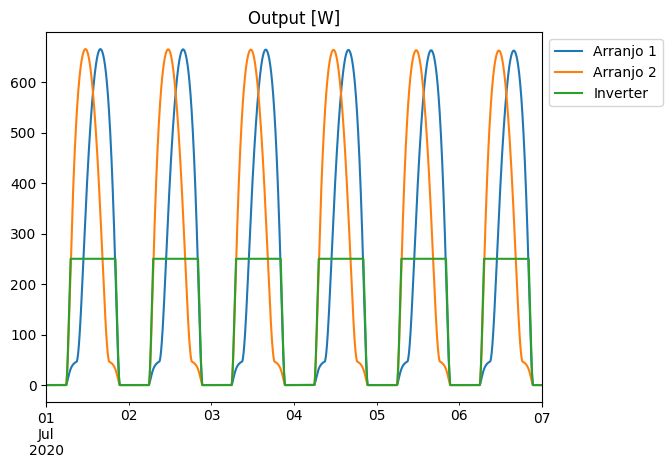

In [14]:

import pvlib
from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.pvsystem import PVSystem
import pandas as pd
import matplotlib.pyplot as plt

modules_per_string = 4
strings_per_inverter = 1


location = Location(latitude=50.941389,
                    longitude=6.958711, tz='Europe/Berlin', altitude=80,
                    name='Cologne')

# Informações mais recentes do módulo e do inversor de um arquivo local ou do Site do SAM.
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

# Calcula a temperatura da célula de acordo com o Sandia Array Performance Model.
temperature_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

times = pd.date_range(start="2020-07-01", end="2020-07-07",
                      freq="1min", tz=location.tz)

# Calcula as estimativas de céu claro de GHI, DNI e/ou DHI neste local.
clear_sky = location.get_clearsky(times)

arrays = [
    Array(FixedMount(surface_tilt=30, surface_azimuth=270),
          name="Arranjo 1",
          module_parameters=module,
          temperature_model_parameters=temperature_parameters,
          modules_per_string=modules_per_string,
          strings=strings_per_inverter
          ),
    Array(FixedMount(surface_tilt=30, surface_azimuth=90),
          name="Arranjo 2",
          module_parameters=module,
          temperature_model_parameters=temperature_parameters,
          modules_per_string=modules_per_string,
          strings=strings_per_inverter
          )
    ]

# O representa um inversor e o módulos fotovoltaicos que fornecem energia DC para o inversor.
system = PVSystem(arrays=arrays, inverter_parameters=inverter)
modelchain = ModelChain(system, location)
modelchain.run_model(clear_sky)

fig, ax = plt.subplots()

modelchain.results.dc[0].p_mp.plot(label=system.arrays[0].name, ax=ax)
modelchain.results.dc[1].p_mp.plot(label=system.arrays[1].name, ax=ax)

model_results_final = modelchain.results.ac
model_results_final.plot(label='Inverter', ax=ax)
plt.title('Output [W]')

plt.legend(bbox_to_anchor=(1,1))